Loading MatrixMarket (.mtx) file...
Graph loaded successfully!
Nodes: 17206
Edges: 604867

--- BASIC STRUCTURAL PROPERTIES ---
Density: 0.004086535643794365
Average degree: 70.30884575148204
Max degree: 1709


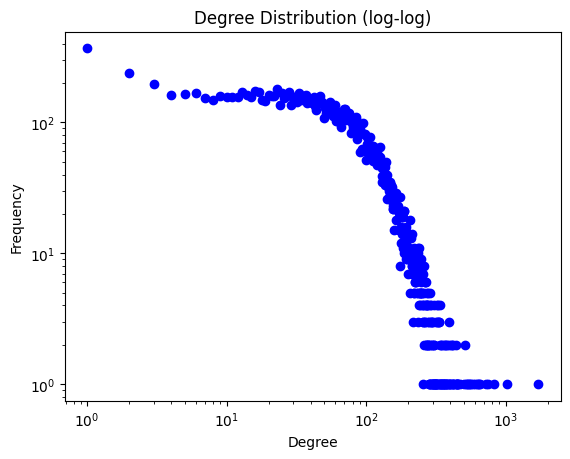


--- CENTRALITIES ---
Computing approximate betweenness (k=300)...
Computing approximate closeness (400 samples)...

Top 5 betweenness:
[(852, 0.04611102799490895), (14539, 0.01667369047637687), (16568, 0.008015917036182442), (3056, 0.006517086690272313), (4139, 0.005265781012984422)]

Top 5 closeness:
[(852, 0.5037783375314862), (14539, 0.4819277108433735), (10754, 0.46893317702227433), (13147, 0.46296296296296297), (16568, 0.4608294930875576)]

--- CONNECTED COMPONENTS ---
Number of components: 1
Largest component: 17206


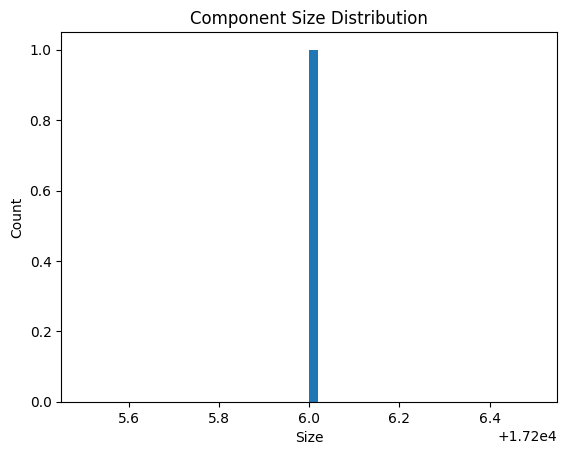


Creating visualization subgraph...

Exporting hub-centered subgraph for Gephi visualization...
Export complete: hub_subgraph_for_gephi.gexf


In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections
import statistics
from scipy.io import mmread  

# =========================
# LOAD .MTX GRAPH
# =========================

FILE = "socfb-UConn.mtx" 

print("Loading MatrixMarket (.mtx) file...")
A = mmread(FILE)                     # SciPy loads sparse matrix
G = nx.from_scipy_sparse_array(A)    # convert to NetworkX Graph

G = nx.Graph(G)                       # ensure simple undirected
G.remove_edges_from(nx.selfloop_edges(G))

print("Graph loaded successfully!")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# =========================
# a) BASIC STRUCTURAL PROPERTIES
# =========================

# i) N, M, Density
n, m = G.number_of_nodes(), G.number_of_edges()
density = nx.density(G)
print("\n--- BASIC STRUCTURAL PROPERTIES ---")
print("Density:", density)

# ii) Degree statistics
degrees = [d for _, d in G.degree()]
avg_deg = sum(degrees)/n
max_deg = max(degrees)

print("Average degree:", avg_deg)
print("Max degree:", max_deg)

deg_count = collections.Counter(degrees)
x, y = zip(*sorted(deg_count.items()))

plt.figure()
plt.loglog(x, y, 'bo')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution (log-log)")
plt.show()


# iii) CENTRALITIES (approx)
print("\n--- CENTRALITIES ---")
print("Computing approximate betweenness (k=300)...")
bet = nx.betweenness_centrality(G, k=300)

print("Computing approximate closeness (400 samples)...")
sample_nodes = list(G.nodes())[:400]
clo = {}
for s in sample_nodes:
    lengths = nx.single_source_shortest_path_length(G, s)
    for node, dist in lengths.items():
        clo[node] = clo.get(node, 0) + dist
clo = {node: (400 / clo[node]) if clo[node] != 0 else 0 for node in clo}

print("\nTop 5 betweenness:")
print(sorted(bet.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 closeness:")
print(sorted(clo.items(), key=lambda x: x[1], reverse=True)[:5])


# v) CONNECTED COMPONENTS
components = list(nx.connected_components(G))
sizes = [len(c) for c in components]

print("\n--- CONNECTED COMPONENTS ---")
print("Number of components:", len(sizes))
print("Largest component:", max(sizes))

plt.figure()
plt.hist(sizes, bins=50)
plt.title("Component Size Distribution")
plt.xlabel("Size")
plt.ylabel("Count")
plt.show()

print("\nCreating visualization subgraph...")





# =========================
# vi) HUB SUBGRAPH – EXPORT FOR GEPHI
# =========================

print("\nExporting hub-centered subgraph for Gephi visualization...")

# Select top hubs
hub_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:80]
hub_nodes = [n for n, _ in hub_nodes]

# Include neighbors of hubs
neighbors = set()
for v in hub_nodes:
    neighbors.update(G.neighbors(v))

subgraph_nodes = set(hub_nodes) | neighbors
H = G.subgraph(subgraph_nodes).copy()

# Add attributes for Gephi visualization
for node in H.nodes():
    H.nodes[node]["degree"] = G.degree(node)
    if "community" in G.nodes[node]:
        H.nodes[node]["community"] = G.nodes[node]["community"]
    H.nodes[node]["is_hub"] = node in hub_nodes

# Export subgraph
nx.write_gexf(H, "hub_subgraph_for_gephi.gexf")

print("Export complete: hub_subgraph_for_gephi.gexf")



In [ ]:
from networkx.algorithms.community import (
    louvain_communities,
    asyn_lpa_communities
)

# -------------------------------------------------
# 1) LOUVAIN COMMUNITY DETECTION
# -------------------------------------------------
print("\n--- Louvain Community Detection ---")

communities_louvain = louvain_communities(G, seed=42)
sizes_louvain = [len(c) for c in communities_louvain]
modularity_louvain = nx.algorithms.community.modularity(G, communities_louvain)

print("Number of communities:", len(sizes_louvain))
print("Min size:", min(sizes_louvain))
print("Avg size:", sum(sizes_louvain)/len(sizes_louvain))
print("Max size:", max(sizes_louvain))
print("Modularity:", modularity_louvain)

plt.figure()
plt.hist(sizes_louvain, bins=50)
plt.title("Louvain Community Size Distribution")
plt.xlabel("Community size")
plt.ylabel("Count")
plt.show()

# Node → community mapping
partition_louvain = {n:i for i,c in enumerate(communities_louvain) for n in c}

# -------------------------------------------------
# 2) LABEL PROPAGATION (FAST)
# -------------------------------------------------
print("\n--- Label Propagation Community Detection ---")

communities_lpa = list(asyn_lpa_communities(G, seed=42))
sizes_lpa = [len(c) for c in communities_lpa]
modularity_lpa = nx.algorithms.community.modularity(G, communities_lpa)

print("Number of communities:", len(sizes_lpa))
print("Min size:", min(sizes_lpa))
print("Avg size:", sum(sizes_lpa)/len(sizes_lpa))
print("Max size:", max(sizes_lpa))
print("Modularity:", modularity_lpa)

plt.figure()
plt.hist(sizes_lpa, bins=50)
plt.title("Label Propagation Community Size Distribution")
plt.xlabel("Community size")
plt.ylabel("Count")
plt.show()

# print("\nCreating visualization subgraph...")

# # -------------------------------------------------
# # SUBGRAPH VISUALIZATION (FAST & INTERPRETABLE)
# # -------------------------------------------------

# print("\nVisualizing hub-centered subgraph...")

# # 1) Select top-k hub nodes
# k = 50
# top_hubs = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:k]
# hub_nodes = [n for n, _ in top_hubs]

# # 2) Include neighbors of hubs
# sub_nodes = set(hub_nodes)
# for n in hub_nodes:
#     sub_nodes.update(G.neighbors(n))

# H = G.subgraph(sub_nodes).copy()

# print("Subgraph nodes:", H.number_of_nodes())
# print("Subgraph edges:", H.number_of_edges())

# # 3) Prepare visualization attributes
# node_sizes = [G.degree(n) * 5 for n in H.nodes()]
# node_colors = [partition_louvain.get(n, -1) for n in H.nodes()]

# # 4) Layout (deterministic & fast)
# pos = nx.spring_layout(H, seed=42, k=0.15)

# # 5) Draw graph
# plt.figure(figsize=(12, 12))

# nx.draw_networkx_edges(
#     H, pos,
#     alpha=0.3,
#     width=0.5
# )

# nx.draw_networkx_nodes(
#     H, pos,
#     node_size=node_sizes,
#     node_color=node_colors,
#     cmap=plt.cm.tab20,
#     alpha=0.85
# )

# # Highlight hub nodes
# nx.draw_networkx_nodes(
#     H, pos,
#     nodelist=hub_nodes,
#     node_size=[G.degree(n) * 5 for n in hub_nodes],
#     node_color="none",
#     edgecolors="red",
#     linewidths=2
# )

# plt.title(
#     "Hub-Centered Subgraph Visualization\n"
#     "(Node size = degree, Color = Louvain community, Red border = hub)",
#     fontsize=13
# )

# plt.axis("off")
# plt.show()



# -------------------------------------------------
# EXPORT NETWORK FOR GEPHI VISUALIZATION
# -------------------------------------------------

print("\nExporting network with community labels for Gephi...")

# Add Louvain community as node attribute
for node, comm_id in partition_louvain.items():
    G.nodes[node]["community"] = comm_id

# Add degree for node sizing in Gephi
for node in G.nodes():
    G.nodes[node]["degree"] = G.degree(node)

# Export to GEXF
nx.write_gexf(G, "socfb_UConn_with_communities.gexf")

print("Export complete: socfb_UConn_with_communities.gexf")



--- Louvain Community Detection ---
